This notebook wants to demonstrate a few things with the grid world example in [this Reinforcement Learning lecture](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/DP.pdf):
1. policy evaluation can converge for a random policy
2. policy iteration and value iteration arrive at same optimised policy
3. early stopping in policy iteration arrive at optimised policy for this example

We are setting up the grid world with 2 terminal states: top left corner and bottom right corner

In [1]:
# first let's model the grid world and policy

class Environment:
    def __init__(self, cells_per_row = 4):
        self.discount = 1
        self.actions = ['up', 'down', 'left', 'right']
        self.grid_size = cells_per_row ** 2
        self.states = range(0, self.grid_size)
        self._cells_per_row = cells_per_row
        
    def is_terminal_state(self, state):
        return state == 0 or state == self.grid_size - 1

    def tick(self, current_state, action):
        # get next state, considering boundaries
        if self.is_terminal_state(current_state):
            return current_state
        
        if action == 'up':
            next_state = current_state - self._cells_per_row
            if next_state < 0:
                return current_state
        elif action == 'down':
            next_state = current_state + self._cells_per_row
            if next_state >= self.grid_size:
                return current_state
        elif action == 'left':
            if current_state % self._cells_per_row == 0:
                return current_state
            next_state = current_state - 1
        elif action == 'right':
            if (current_state+1) % self._cells_per_row == 0:
                return current_state
            next_state = current_state + 1
        
        return next_state
    
    def reward(self, current_state):
        if self.is_terminal_state(current_state):
            return 0
        else:
            return -1

        
class RandomPolicy:
    def __init__(self, environment):
        self.environment = environment
    
    def action(self, current_state):
        if self.environment.is_terminal_state(current_state):
            return {'stay': 1}
        return {e: 1 / len(self.environment.actions) for e in self.environment.actions}

In [2]:
# tests
e = Environment()
assert(e.tick(0, 'up') == 0)
assert(e.tick(0, 'left') == 0)
assert(e.tick(8, 'left') == 8)
assert(e.tick(11, 'right') == 11)
assert(e.tick(14, 'down') == 14)
assert(e.tick(5, 'up') == 1)
assert(e.tick(5, 'down') == 9)
assert(e.tick(5, 'left') == 4)
assert(e.tick(5, 'right') == 6)

p = RandomPolicy(e)
print(p.action(0))
print(p.action(1))

{'stay': 1}
{'up': 0.25, 'down': 0.25, 'left': 0.25, 'right': 0.25}


In [3]:
# 1. policy evaluation should converge
e = Environment()
p = RandomPolicy(e)


def evaluate_policy(policy, iterations):
    values = [0] * e.grid_size    
    for i in range(iterations):
        new_values = [0] * e.grid_size
        for state in e.states:
            for (action, probability) in policy.action(state).items():
                next_state = e.tick(state, action)
                next_state_value = values[next_state]
                reward = e.reward(state)
                new_values[state] += probability * (reward + next_state_value)
        values = new_values
    return values

print([round(e, 0) for e in evaluate_policy(p, 100)]) # this should match values from the slides
        

[0, -14.0, -20.0, -22.0, -14.0, -18.0, -20.0, -20.0, -20.0, -20.0, -18.0, -14.0, -22.0, -20.0, -14.0, 0]


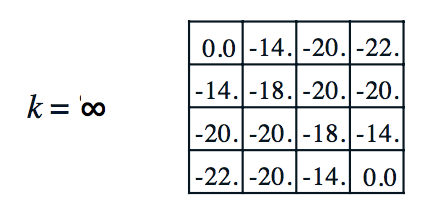

In [4]:
# 2. policy iteration using converged values (no early stopping)
class GreedyPolicy:
    def __init__(self, environment, random_policy_values):
        self.environment = environment
        self.random_policy_values = random_policy_values
    
    def action(self, state):
        if self.environment.is_terminal_state(state):
            return {'stay':1}
        else:
            # take the action that yield most value increase
            choices = {}
            for action in self.environment.actions:
                next_state = self.environment.tick(state, action)
                incremental_value = self.random_policy_values[next_state] - self.random_policy_values[state]
                choices[action] = incremental_value
            choices_sorted = sorted(choices, key=choices.get, reverse=True)
            # cheating here, we know most actions the best policy can take is 2
            fst = choices_sorted[0]
            snd = choices_sorted[1]
            if round(choices[fst], 2) == round(choices[snd], 2):
                return {fst: 0.5, snd: 0.5}
            return {choices_sorted[0]: 1}

In [5]:
values = evaluate_policy(p, 100)
gp = GreedyPolicy(e, values)
for s in e.states:
    print(gp.action(s)) # this should match with slides

{'stay': 1}
{'left': 1}
{'left': 1}
{'down': 0.5, 'left': 0.5}
{'up': 1}
{'left': 0.5, 'up': 0.5}
{'down': 0.5, 'left': 0.5}
{'down': 1}
{'up': 1}
{'up': 0.5, 'right': 0.5}
{'down': 0.5, 'right': 0.5}
{'down': 1}
{'up': 0.5, 'right': 0.5}
{'right': 1}
{'right': 1}
{'stay': 1}


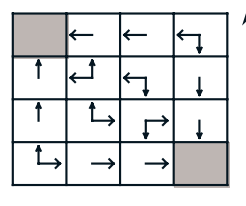

In [6]:
# now what if we stop early in random policy evaluation? 
# in this example stop after iteration 3 would give you optimised policy
values = evaluate_policy(p, 3)
gp_earlystopping = GreedyPolicy(e, values)
for s in e.states:
    print(gp_earlystopping.action(s)) # this should be same policy with previous cell

{'stay': 1}
{'left': 1}
{'left': 1}
{'down': 0.5, 'left': 0.5}
{'up': 1}
{'up': 0.5, 'left': 0.5}
{'down': 0.5, 'left': 0.5}
{'down': 1}
{'up': 1}
{'up': 0.5, 'right': 0.5}
{'down': 0.5, 'right': 0.5}
{'down': 1}
{'up': 0.5, 'right': 0.5}
{'right': 1}
{'right': 1}
{'stay': 1}


In [7]:
# let's see what is the value for the final optimised policy
print([round(e, 0) for e in evaluate_policy(gp, 100)])

[0, -1, -2, -3.0, -1, -2.0, -3.0, -2, -2, -3.0, -2.0, -1, -3.0, -2, -1, 0]


In [8]:
# 3. value iteration should give same optimised policy, with less iterations
e = Environment()
values = [0] * e.grid_size
known_states = [0, e.grid_size-1]


def iteration(values, known_states):
    new_values = values.copy()
    new_known_states = known_states.copy()
    for state in e.states:
        if e.is_terminal_state(state) or state in known_states:
            continue
        v = values[state]
        max_reward = float('-inf')
        updatable = False
        for action in e.actions:
            next_state = e.tick(state, action)
            if next_state in known_states:
                updatable = True
                reward = e.reward(state)
                next_state_value = values[next_state]
                total = reward + e.discount * next_state_value
                if total >= max_reward:
                    max_reward = total
        if updatable:
            new_values[state] = max_reward
            new_known_states.append(state)
    return new_values, new_known_states

i = 0
while len(known_states) < e.grid_size:
    values, known_states = iteration(values, known_states)
    print("=== iteration", i)
    i += 1
    print("values: ", values)
    print("known states: ", known_states)

print("=" * 10)
print("final values")
print(values) # this should match previous cell's result      

=== iteration 0
values:  [0, -1, 0, 0, -1, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0]
known states:  [0, 15, 1, 4, 11, 14]
=== iteration 1
values:  [0, -1, -2, 0, -1, -2, 0, -2, -2, 0, -2, -1, 0, -2, -1, 0]
known states:  [0, 15, 1, 4, 11, 14, 2, 5, 7, 8, 10, 13]
=== iteration 2
values:  [0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1, 0]
known states:  [0, 15, 1, 4, 11, 14, 2, 5, 7, 8, 10, 13, 3, 6, 9, 12]
final values
[0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1, 0]
